In [1]:
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors

In [2]:
df = pd.read_csv("/Users/alsabbaghs/Downloads/seeds_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     210 non-null    float64
 1   Perimeter                210 non-null    float64
 2   Compactness              210 non-null    float64
 3   Length of Kernal         210 non-null    float64
 4   Width of Kernal          210 non-null    float64
 5   Asymmetric Coefficient   210 non-null    float64
 6   Length of Kernal Groove  210 non-null    float64
 7   Class                    210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop("Class", axis = 1), df["Class"], test_size = 0.2857, random_state = 42, shuffle = True)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(150, 7) (150,) (60, 7) (60,)


In [4]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled

#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range



In [5]:
#tuning parameters/ hyperparameters
#could alter the value of accuracy 

num_rows = 10
num_cols = 10
max_m_dsitance = 7
max_learning_rate = 0.5
max_steps = 100000

num_nurons = 7 * np.sqrt(X_train.shape[0])
grid_size = ceil(np.sqrt(num_nurons))
print(grid_size)

10.0


In [6]:
#mian function

train_x_norm = minmax_scaler(X_train) # normalisation
print(train_x_norm)

# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

[[0.07932011 0.14876033 0.2473223  ... 0.0634355  0.18930164 0.3097524 ]
 [0.36543909 0.40082645 0.71762415 ... 0.53243051 0.26484547 0.2652855 ]
 [0.79225685 0.85950413 0.59006816 ... 0.65716322 0.17928981 0.97726124]
 ...
 [0.77620397 0.80165289 0.80331061 ... 0.75766215 0.32140582 0.77513896]
 [0.1529745  0.21900826 0.36222006 ... 0.18745545 0.11648832 0.33299646]
 [0.83758263 0.84504132 0.88023369 ... 0.89950107 0.4606613  0.75290551]]
Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iterati

In [7]:
label_data = np.array(Y_train)
map = np.empty(shape=(num_rows, num_cols), dtype=object)
#print(len(label_data))

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  #print(winner)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

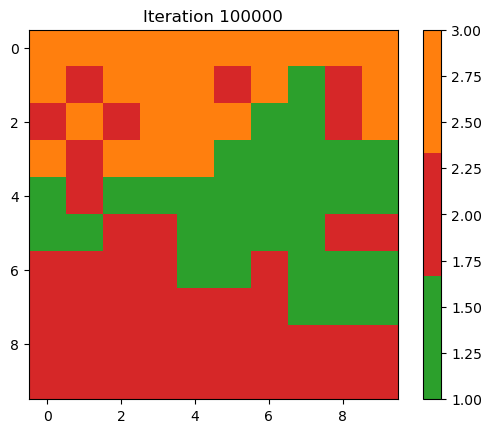

In [8]:
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 2
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [9]:
# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data = minmax_scaler(X_test) # normalisation

winner_labels = []

for t in range(data.shape[0]):
 winner = winning_neuron(data, t, som, num_rows, num_cols)
 row = winner[0]
 col = winner[1]
 predicted = label_map[row][col]
 winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(Y_test, np.array(winner_labels)))

Accuracy:  0.8
